This notebook contains BDT variables' distribution for signals of representative parameter points. **Triggered only**.

Leading and subleading leptonJets' distributions are plotted separately.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot
from awkward import JaggedArray

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.correction import get_pu_weights_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

scale4mu_ = json.load(open('../Samples/signal_4mu_scale.json'))
scale2mu2e_ = json.load(open('../Samples/signal_2mu2e_scale.json'))

In [3]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dict(files=dataset4mu_['mXX-100_mA-5_lxy-300'], treename='ffNtuplizer/ffNtuple'),
    '4mu/mXX-1000_mA-0p25_lxy-300': dict(files=dataset4mu_['mXX-1000_mA-0p25_lxy-300'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-100_mA-5_lxy-300': dict(files=dataset2mu2e_['mXX-100_mA-5_lxy-300'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dict(files=dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'], treename='ffNtuplizer/ffNtuple'),
}

lumi = 60.432
scales={}
for k in scale4mu_:
    scales[f'4mu/{k}'] = lumi * scale4mu_[k]
for k in scale2mu2e_:
    scales[f'2mu2e/{k}'] = lumi * scale2mu2e_[k]

## Variables as input for BDT
- leptonJet pT, eta
- neutral energy fraction
- maxd0, mind0
- tkiso, pfiso
- spreadpt, spreaddr
- lambda, epsilon
- ecf 1,2,3

and
- BDT score

In [4]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'selected signal datasets')
        pt0_axis      = hist.Bin("pt", "pT [GeV]", 50, 0, 200) # small range
        pt1_axis      = hist.Bin("pt", "pT [GeV]", 50, 0, 750) # large range
        
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        mass_axis     = hist.Bin("mass", "mass [GeV]", 50, 0, 20)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 750)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 2000)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 1000)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'lead_pt0'     : hist.Hist("#counts/4GeV", dataset_axis, pt0_axis),
            'lead_pt1'     : hist.Hist("#counts/15GeV", dataset_axis, pt1_axis),
            "lead_eta"     : hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "lead_mass"    : hist.Hist("#counts/0.4GeV", dataset_axis, mass_axis),
            "lead_nef"     : hist.Hist("#counts/0.02", dataset_axis, nef_axis),
            "lead_maxd0"   : hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "lead_mind0"   : hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "lead_tkiso"   : hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "lead_pfiso"   : hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "lead_spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "lead_spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "lead_lamb"    : hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "lead_epsi"    : hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "lead_ecfe1"   : hist.Hist("#counts/15", dataset_axis, ecfe1_axis),
            "lead_ecfe2"   : hist.Hist("#counts/40", dataset_axis, ecfe2_axis),
            "lead_ecfe3"   : hist.Hist("#counts/20", dataset_axis, ecfe3_axis),
            "lead_mva"     : hist.Hist("#counts/0.4", dataset_axis, mva_axis),
            
            'subl_pt0'     : hist.Hist("#counts/4GeV", dataset_axis, pt0_axis),
            'subl_pt1'     : hist.Hist("#counts/15GeV", dataset_axis, pt1_axis),
            "subl_eta"     : hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "subl_mass"    : hist.Hist("#counts/0.4GeV", dataset_axis, mass_axis),
            "subl_nef"     : hist.Hist("#counts/0.02", dataset_axis, nef_axis),
            "subl_maxd0"   : hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "subl_mind0"   : hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "subl_tkiso"   : hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "subl_pfiso"   : hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "subl_spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "subl_spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "subl_lamb"    : hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "subl_epsi"    : hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "subl_ecfe1"   : hist.Hist("#counts/15", dataset_axis, ecfe1_axis),
            "subl_ecfe2"   : hist.Hist("#counts/40", dataset_axis, ecfe2_axis),
            "subl_ecfe3"   : hist.Hist("#counts/20", dataset_axis, ecfe3_axis),
            "subl_mva"     : hist.Hist("#counts/0.4", dataset_axis, mva_axis),
        })
        self.pucorrs = get_pu_weights_function()

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        wgts.add('trigger', triggermask)
        
        weight = wgts.weight()
        ########################
        
        maxd0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).max()
        mind0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=maxd0_.content,
            mind0=mind0_.content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        
        ## apply gen matching ##
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        leptonjets = leptonjets[matchmask]
        
        ## two leptonJets ##
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        weight = weight[twoleptonjets]
        
        leadlj = dileptonjets[dileptonjets.pt.argmax()]
        subllj = dileptonjets[JaggedArray.fromfolding(dileptonjets.pt.argsort()[:, 1], 1)]
        
        output['lead_pt0']     .fill(dataset=dataset, pt=leadlj.p4.pt.flatten(), weight=weight)
        output['lead_pt1']     .fill(dataset=dataset, pt=leadlj.p4.pt.flatten(), weight=weight)
        output['lead_eta']     .fill(dataset=dataset, eta=leadlj.p4.eta.flatten(), weight=weight)
        output['lead_mass']    .fill(dataset=dataset, mass=leadlj.p4.mass.flatten(), weight=weight)
        output['lead_nef']     .fill(dataset=dataset, nef=leadlj.nef.flatten(), weight=weight)
        output['lead_maxd0']   .fill(dataset=dataset, maxd0=leadlj.maxd0.flatten(), weight=weight)
        output['lead_mind0']   .fill(dataset=dataset, mind0=leadlj.mind0.flatten(), weight=weight)
        output['lead_tkiso']   .fill(dataset=dataset, tkiso=leadlj.tkiso.flatten(), weight=weight)
        output['lead_pfiso']   .fill(dataset=dataset, pfiso=leadlj.pfiso.flatten(), weight=weight)
        output['lead_spreadpt'].fill(dataset=dataset, spreadpt=leadlj.spreadpt.flatten(), weight=weight)
        output['lead_spreaddr'].fill(dataset=dataset, spreaddr=leadlj.spreaddr.flatten(), weight=weight)
        output['lead_lamb']    .fill(dataset=dataset, lamb=leadlj.lamb.flatten(), weight=weight)
        output['lead_epsi']    .fill(dataset=dataset, epsi=leadlj.epsi.flatten(), weight=weight)
        output['lead_ecfe1']   .fill(dataset=dataset, ecfe1=leadlj.ecf1.flatten(), weight=weight)
        output['lead_ecfe2']   .fill(dataset=dataset, ecfe2=leadlj.ecf2.flatten(), weight=weight)
        output['lead_ecfe3']   .fill(dataset=dataset, ecfe3=leadlj.ecf3.flatten(), weight=weight)
        output['lead_mva']     .fill(dataset=dataset, mva=leadlj.mva.flatten(), weight=weight)

        output['subl_pt0']     .fill(dataset=dataset, pt=subllj.p4.pt.flatten(), weight=weight)
        output['subl_pt1']     .fill(dataset=dataset, pt=subllj.p4.pt.flatten(), weight=weight)
        output['subl_eta']     .fill(dataset=dataset, eta=subllj.p4.eta.flatten(), weight=weight)
        output['subl_mass']    .fill(dataset=dataset, mass=subllj.p4.mass.flatten(), weight=weight)
        output['subl_nef']     .fill(dataset=dataset, nef=subllj.nef.flatten(), weight=weight)
        output['subl_maxd0']   .fill(dataset=dataset, maxd0=subllj.maxd0.flatten(), weight=weight)
        output['subl_mind0']   .fill(dataset=dataset, mind0=subllj.mind0.flatten(), weight=weight)
        output['subl_tkiso']   .fill(dataset=dataset, tkiso=subllj.tkiso.flatten(), weight=weight)
        output['subl_pfiso']   .fill(dataset=dataset, pfiso=subllj.pfiso.flatten(), weight=weight)
        output['subl_spreadpt'].fill(dataset=dataset, spreadpt=subllj.spreadpt.flatten(), weight=weight)
        output['subl_spreaddr'].fill(dataset=dataset, spreaddr=subllj.spreaddr.flatten(), weight=weight)
        output['subl_lamb']    .fill(dataset=dataset, lamb=subllj.lamb.flatten(), weight=weight)
        output['subl_epsi']    .fill(dataset=dataset, epsi=subllj.epsi.flatten(), weight=weight)
        output['subl_ecfe1']   .fill(dataset=dataset, ecfe1=subllj.ecf1.flatten(), weight=weight)
        output['subl_ecfe2']   .fill(dataset=dataset, ecfe2=subllj.ecf2.flatten(), weight=weight)
        output['subl_ecfe3']   .fill(dataset=dataset, ecfe3=subllj.ecf3.flatten(), weight=weight)
        output['subl_mva']     .fill(dataset=dataset, mva=subllj.mva.flatten(), weight=weight)
        
        return output
    
    def postprocess(self, accumulator):
        for k in accumulator:
            accumulator[k].scale(scales, axis='dataset')
        return accumulator

In [5]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:05<00:00,  1.23items/s]


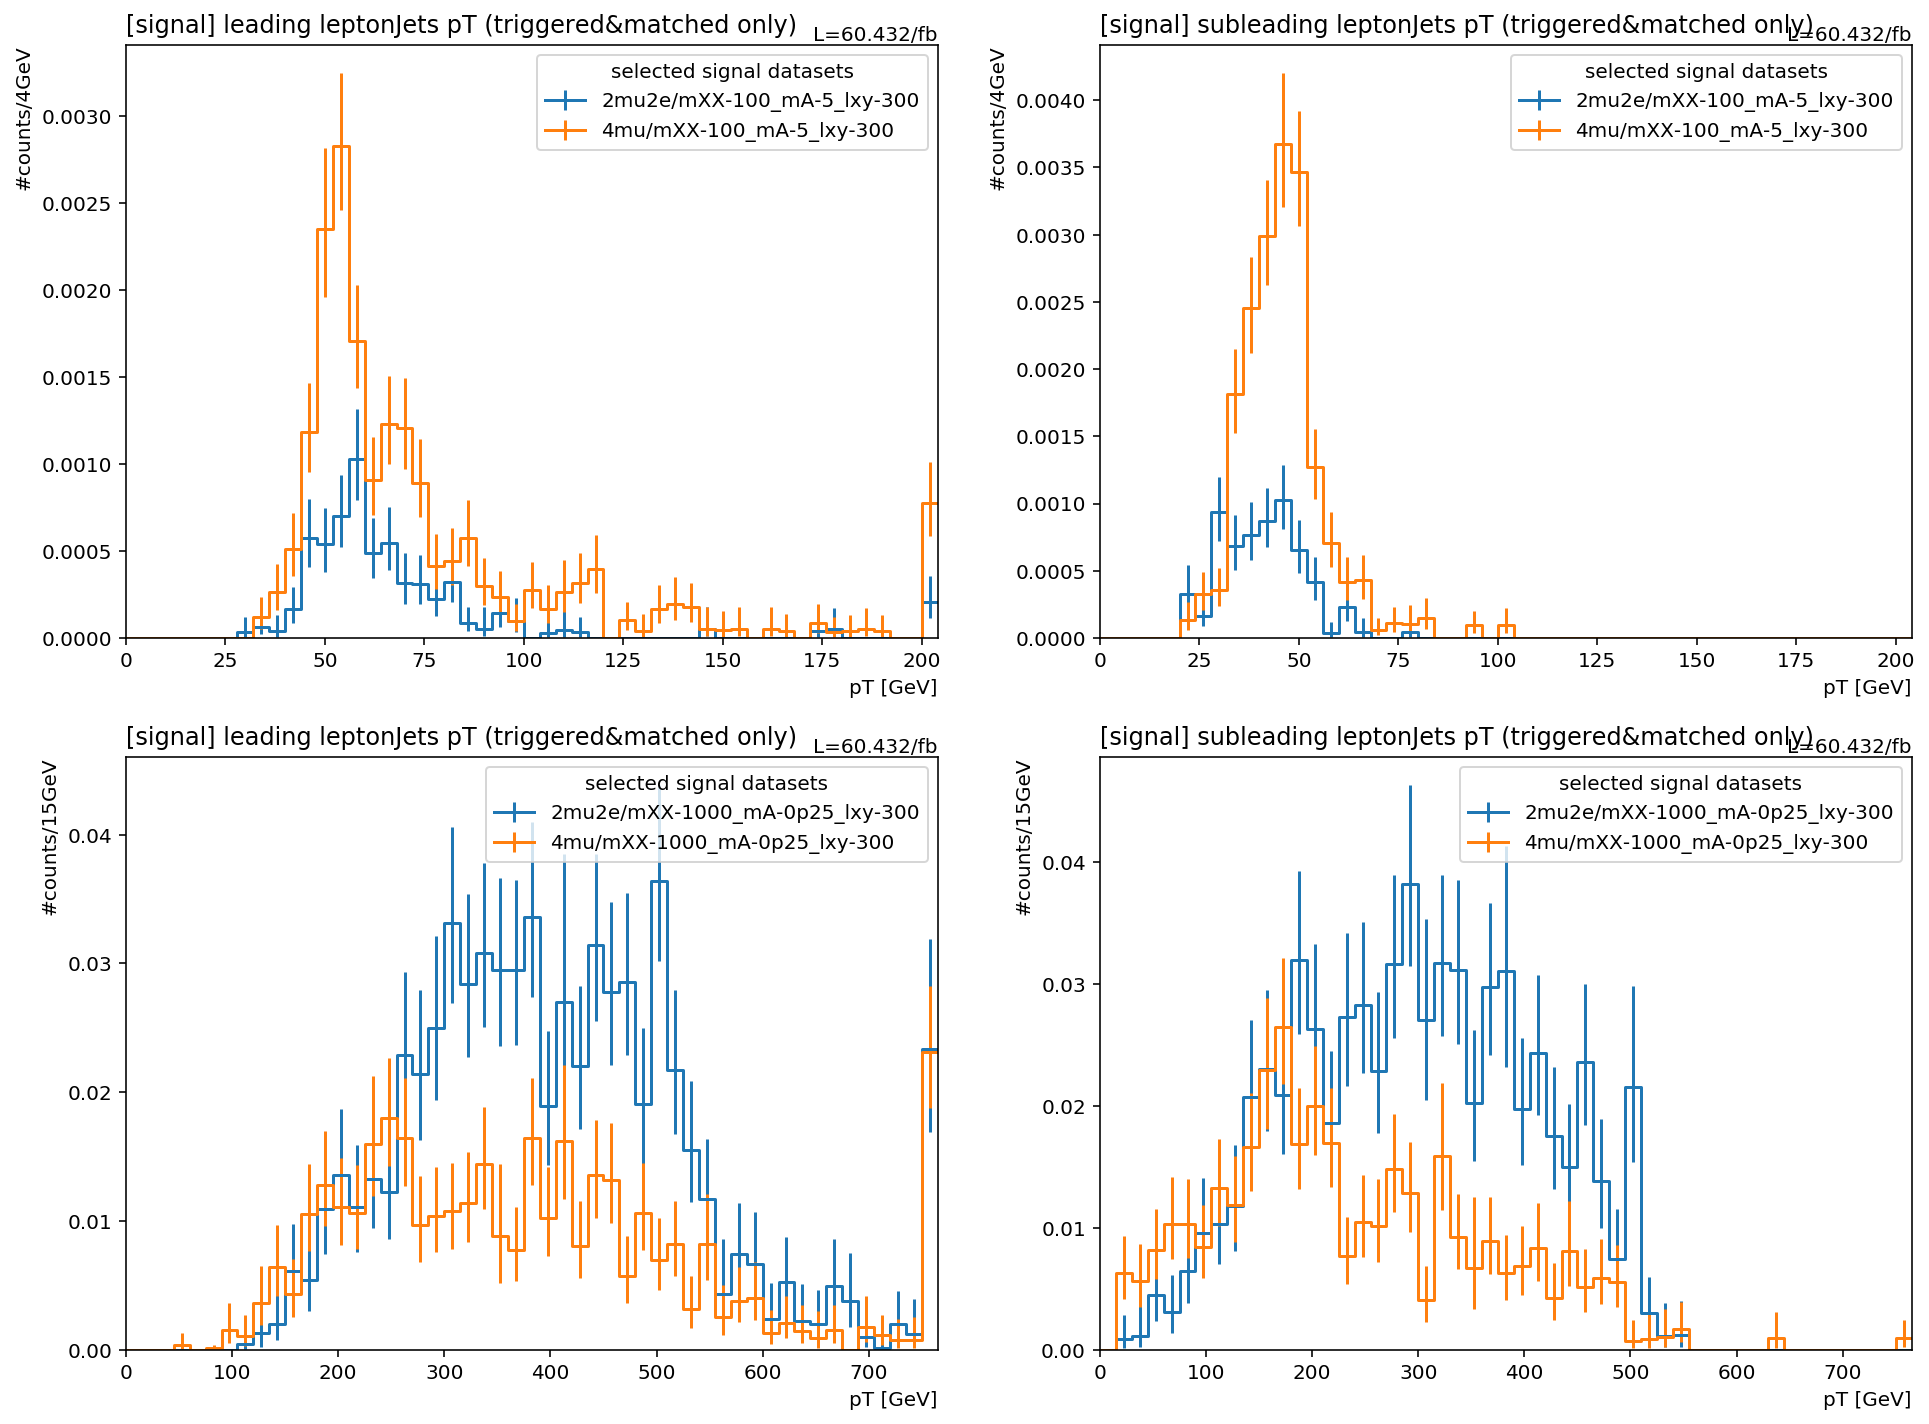

In [6]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
hist.plot1d(output['lead_pt0']['*/mXX-100_mA-5*'], overlay='dataset', ax=axes[0][0], density=False, overflow='over')
hist.plot1d(output['subl_pt0']['*/mXX-100_mA-5*'], overlay='dataset', ax=axes[0][1], density=False, overflow='over')
hist.plot1d(output['lead_pt1']['*/mXX-1000_mA-0p25*'], overlay='dataset', ax=axes[1][0], density=False, overflow='over')
hist.plot1d(output['subl_pt1']['*/mXX-1000_mA-0p25*'], overlay='dataset', ax=axes[1][1], density=False, overflow='over')

axes[0][0].set_title('[signal] leading leptonJets pT (triggered&matched only)', x=0.0, ha="left")
axes[0][1].set_title('[signal] subleading leptonJets pT (triggered&matched only)', x=0.0, ha="left")
axes[1][0].set_title('[signal] leading leptonJets pT (triggered&matched only)', x=0.0, ha="left")
axes[1][1].set_title('[signal] subleading leptonJets pT (triggered&matched only)', x=0.0, ha="left")

for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

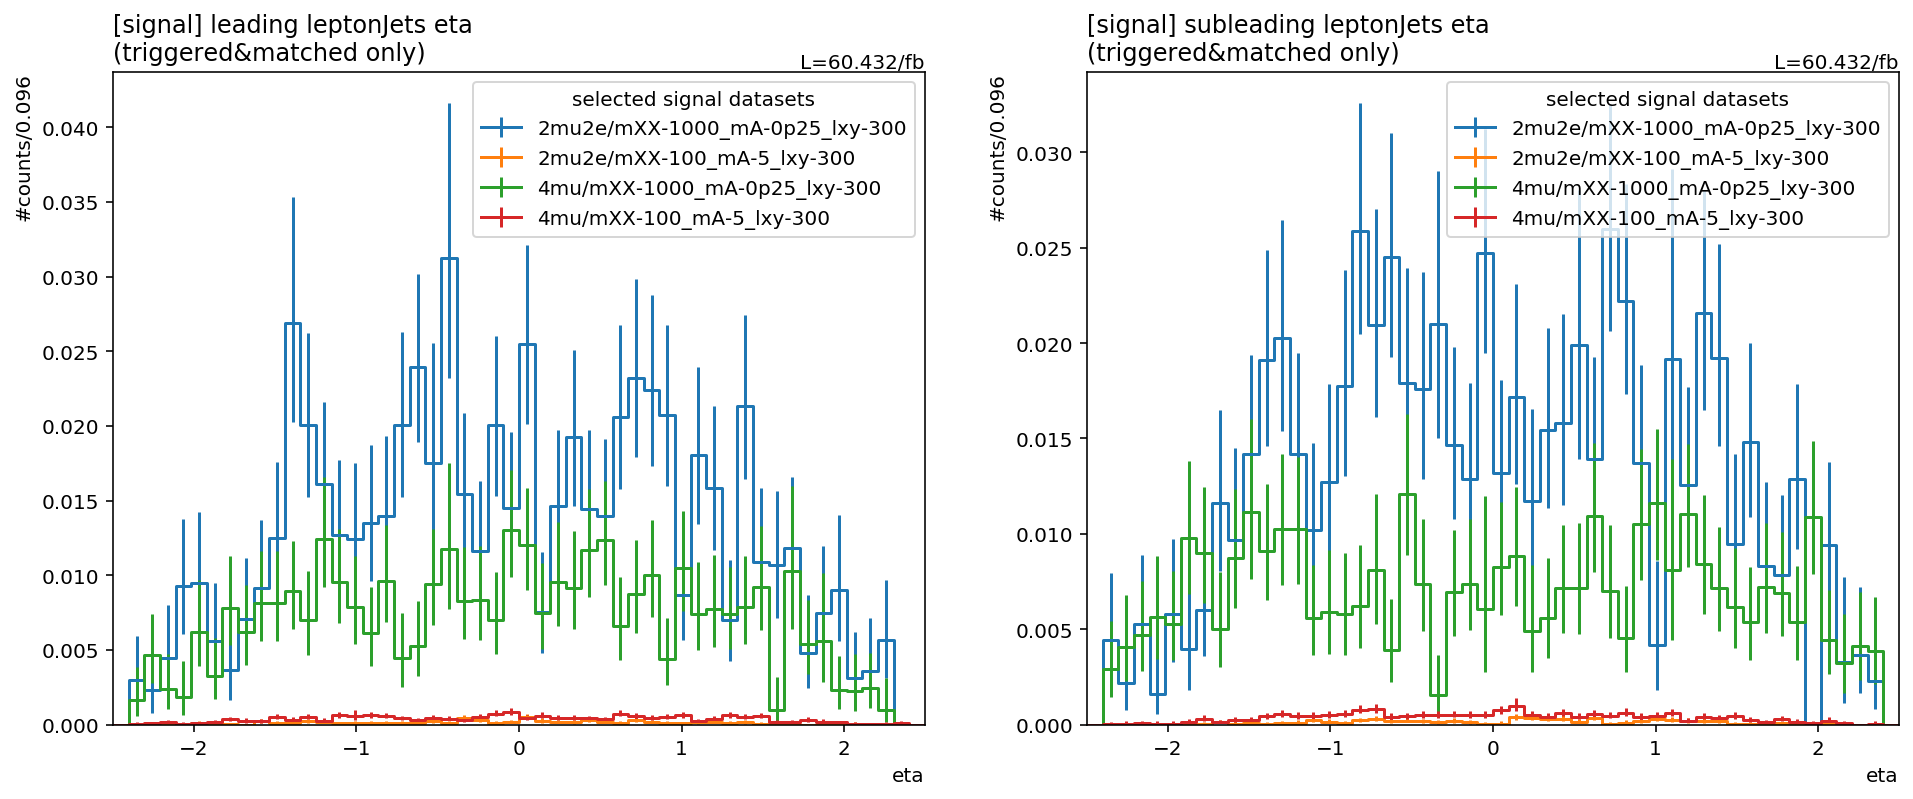

In [7]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_eta'], overlay='dataset', ax=axes[0], density=False, overflow='all')
hist.plot1d(output['subl_eta'], overlay='dataset', ax=axes[1], density=False, overflow='all')

axes[0].set_title('[signal] leading leptonJets eta\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets eta\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

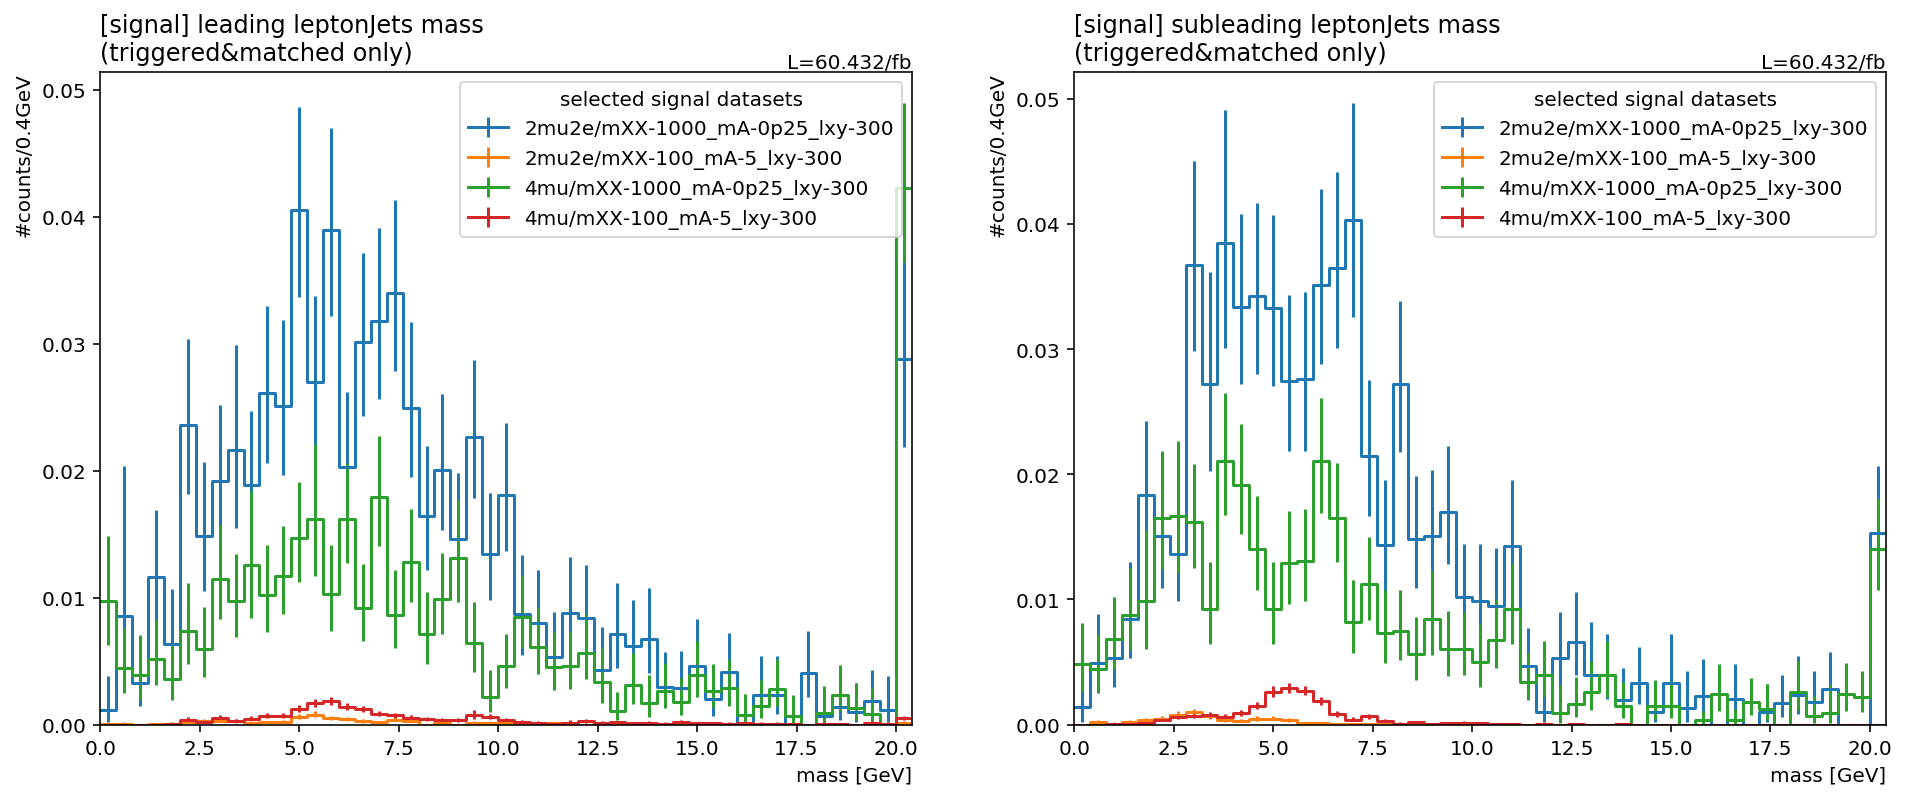

In [8]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_mass'], overlay='dataset', ax=axes[0], density=False, overflow='over')
hist.plot1d(output['subl_mass'], overlay='dataset', ax=axes[1], density=False, overflow='over')

axes[0].set_title('[signal] leading leptonJets mass\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets mass\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

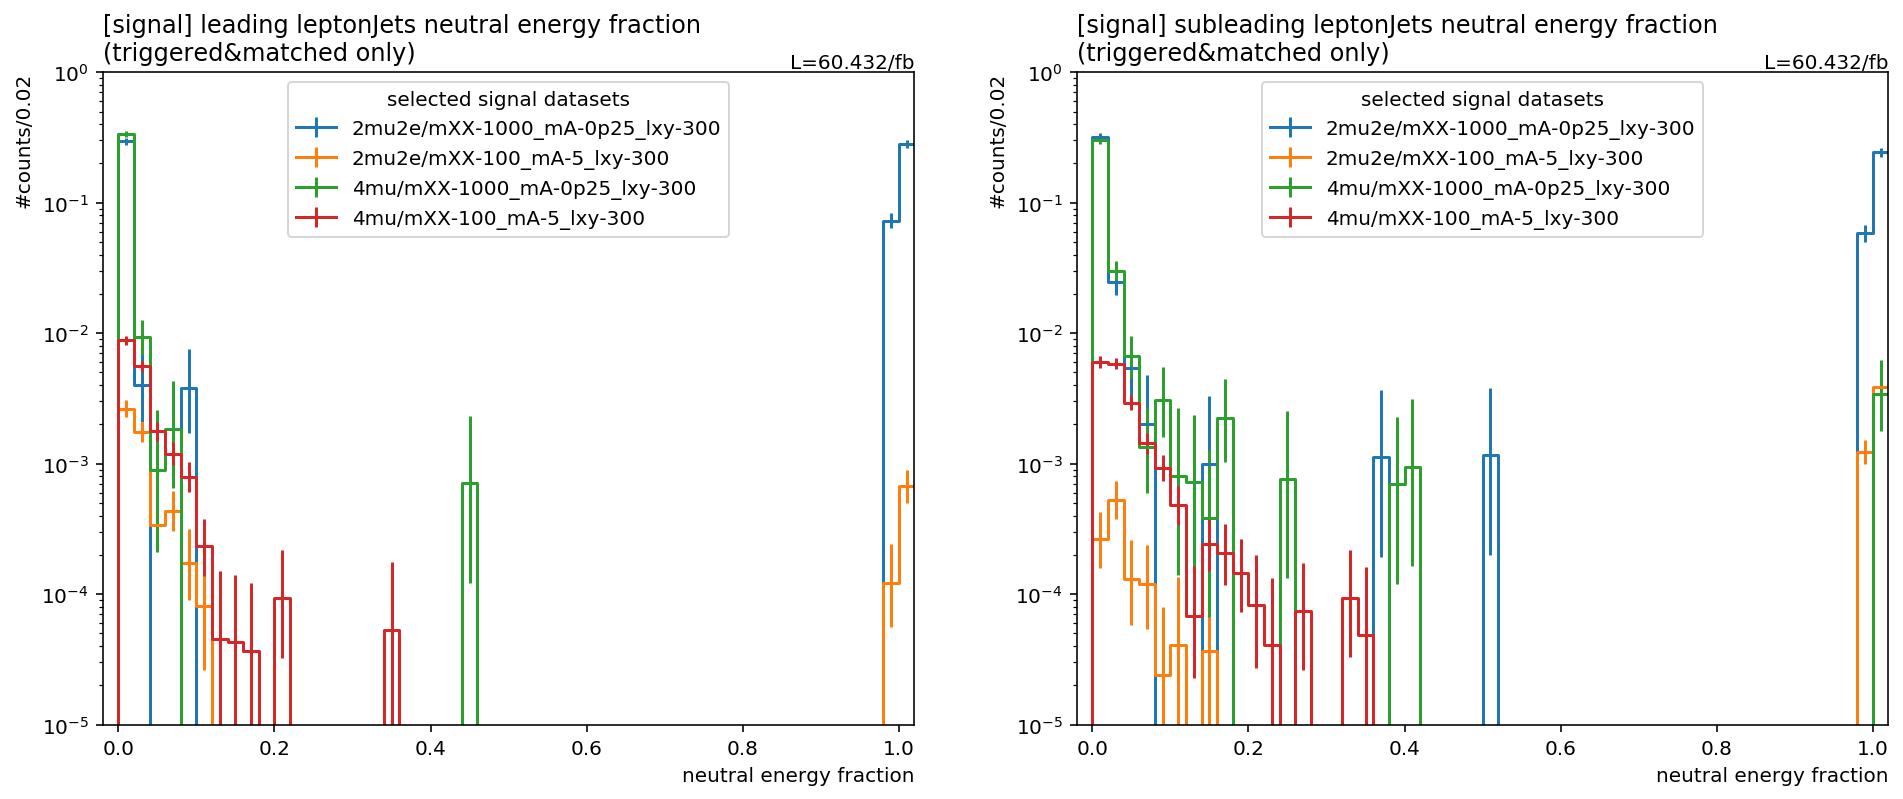

In [9]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_nef'], overlay='dataset', ax=axes[0], density=False, overflow='all')
hist.plot1d(output['subl_nef'], overlay='dataset', ax=axes[1], density=False, overflow='all')

axes[0].set_title('[signal] leading leptonJets neutral energy fraction\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets neutral energy fraction\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

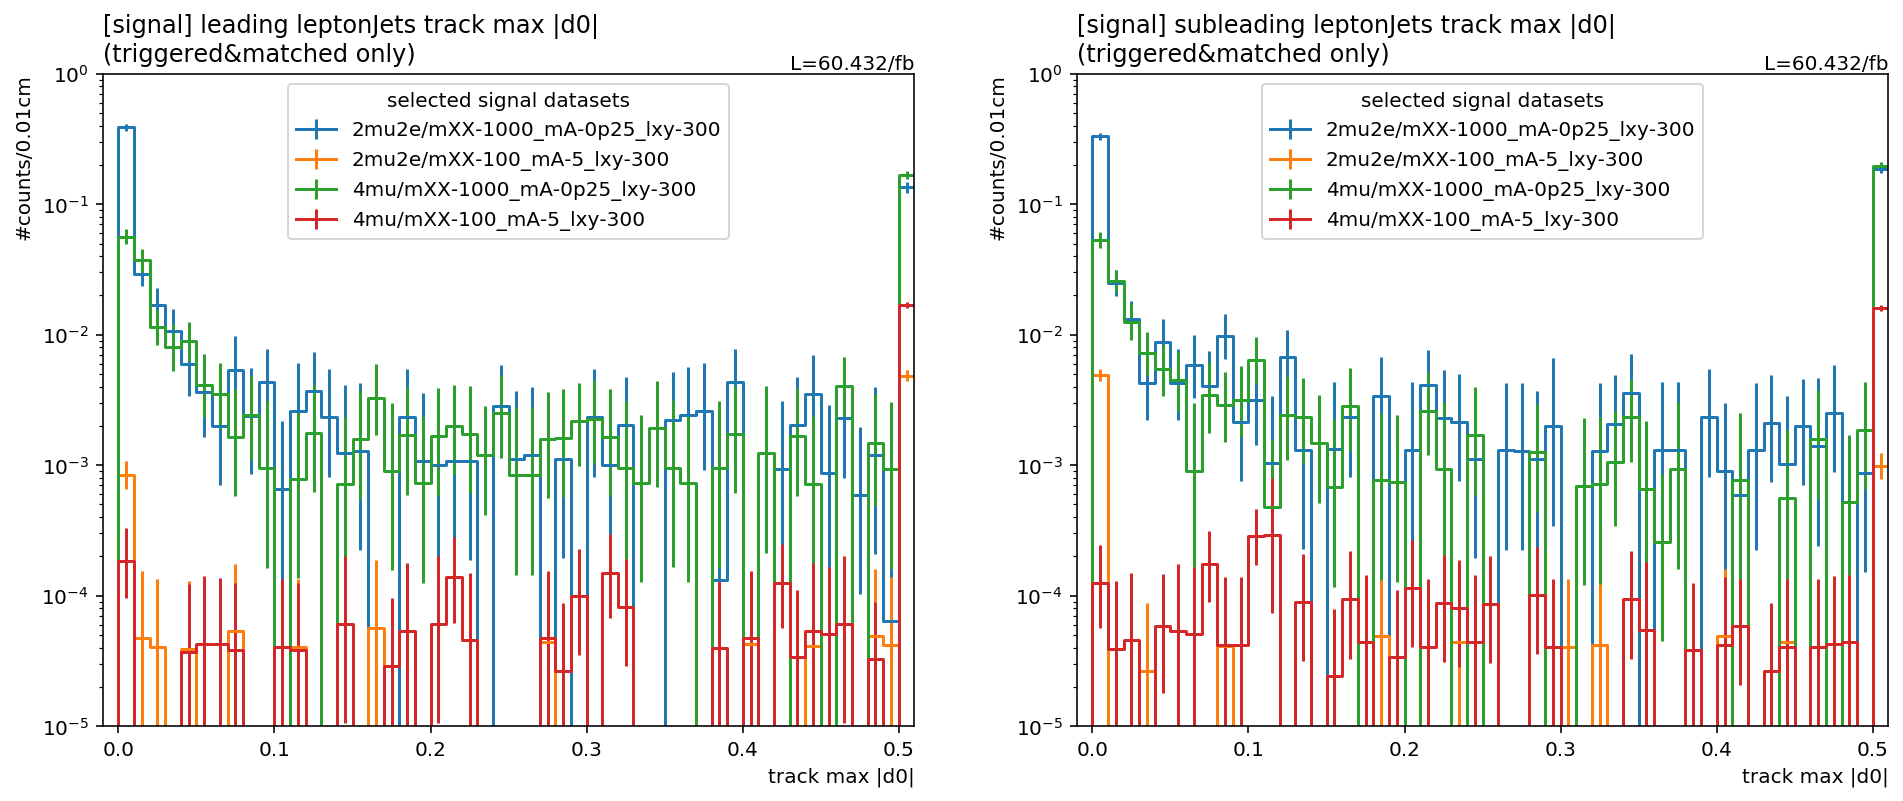

In [10]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_maxd0'], overlay='dataset', ax=axes[0], density=False, overflow='all')
hist.plot1d(output['subl_maxd0'], overlay='dataset', ax=axes[1], density=False, overflow='all')

axes[0].set_title('[signal] leading leptonJets track max |d0|\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets track max |d0|\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

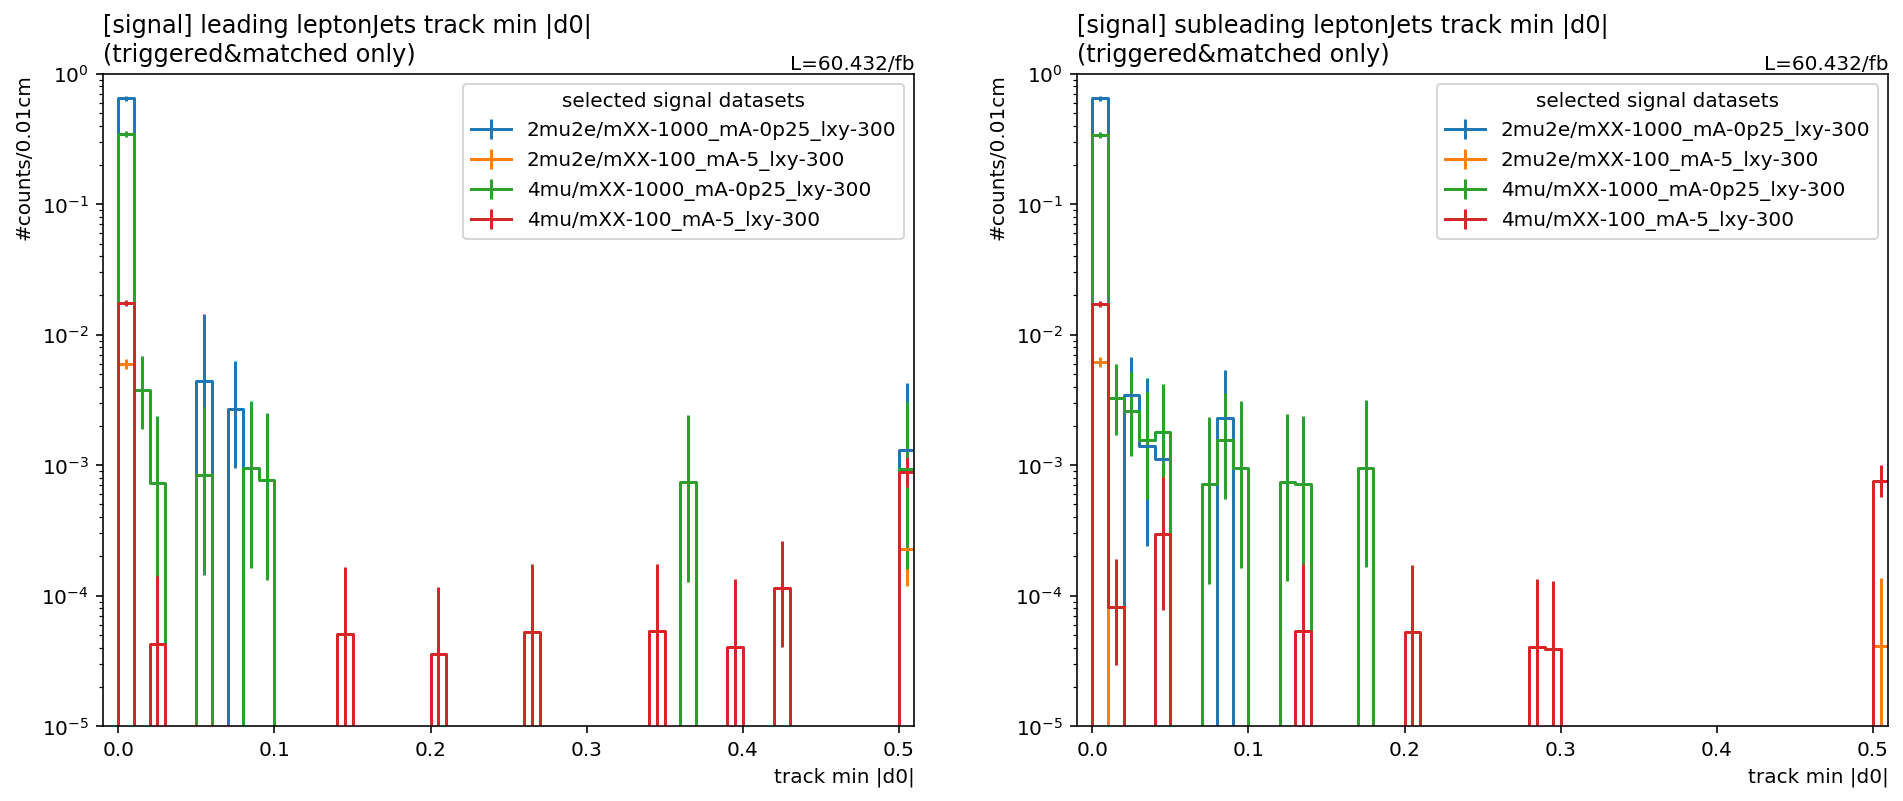

In [11]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_mind0'], overlay='dataset', ax=axes[0], density=False, overflow='all')
hist.plot1d(output['subl_mind0'], overlay='dataset', ax=axes[1], density=False, overflow='all')

axes[0].set_title('[signal] leading leptonJets track min |d0|\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets track min |d0|\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

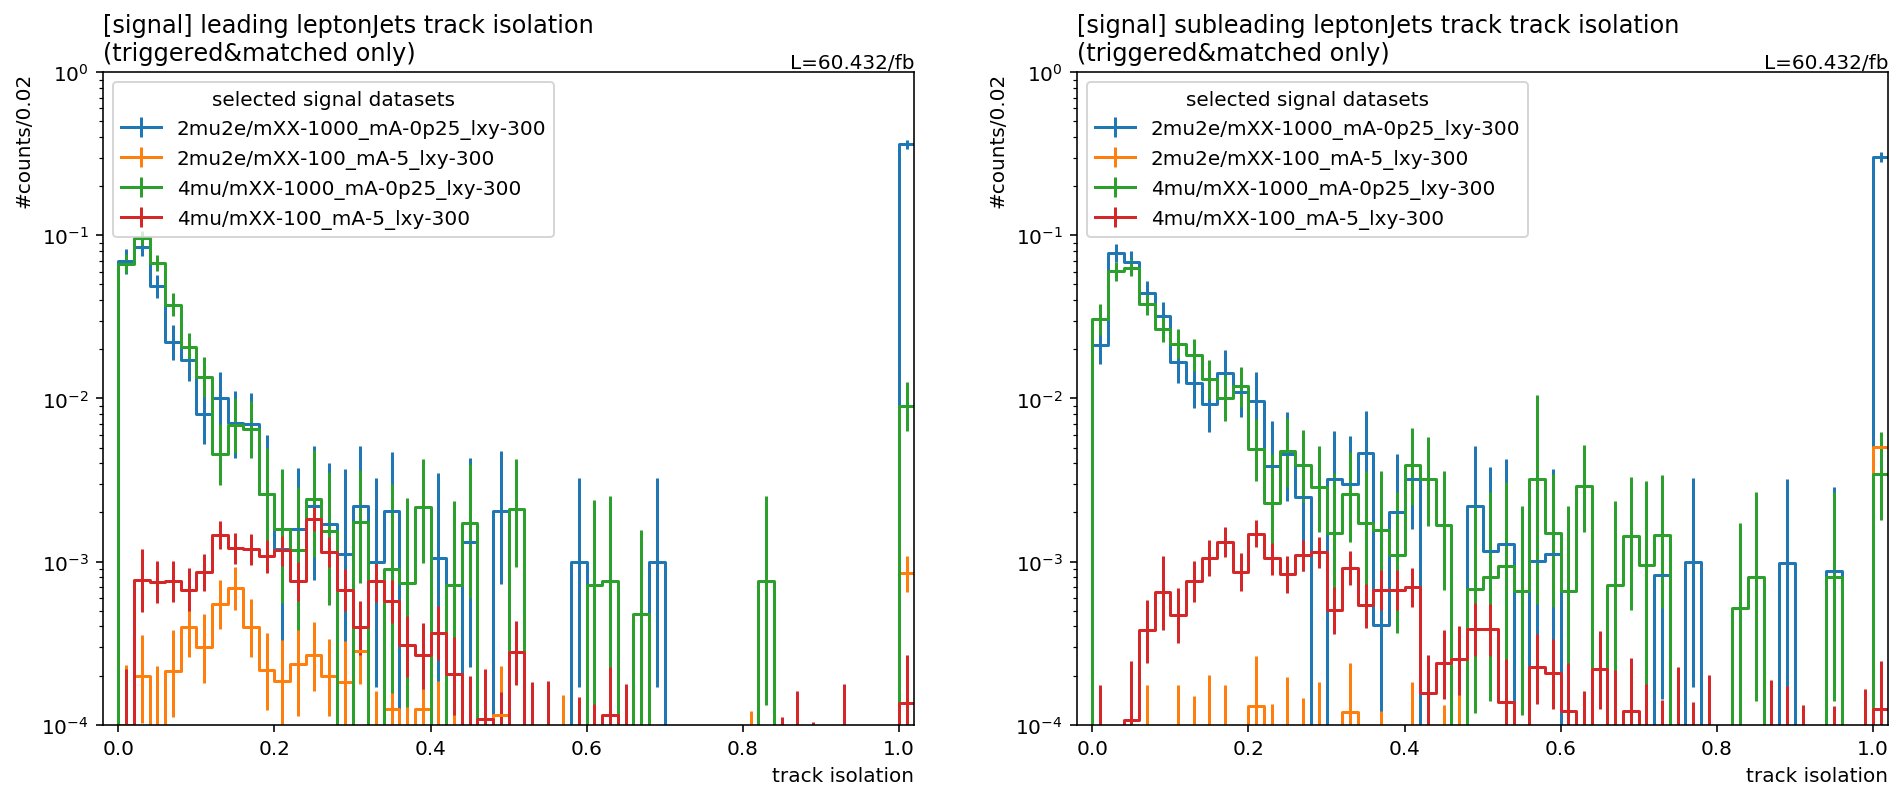

In [12]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_tkiso'], overlay='dataset', ax=axes[0], density=False, overflow='all')
hist.plot1d(output['subl_tkiso'], overlay='dataset', ax=axes[1], density=False, overflow='all')

axes[0].set_title('[signal] leading leptonJets track isolation\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets track track isolation\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-4, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

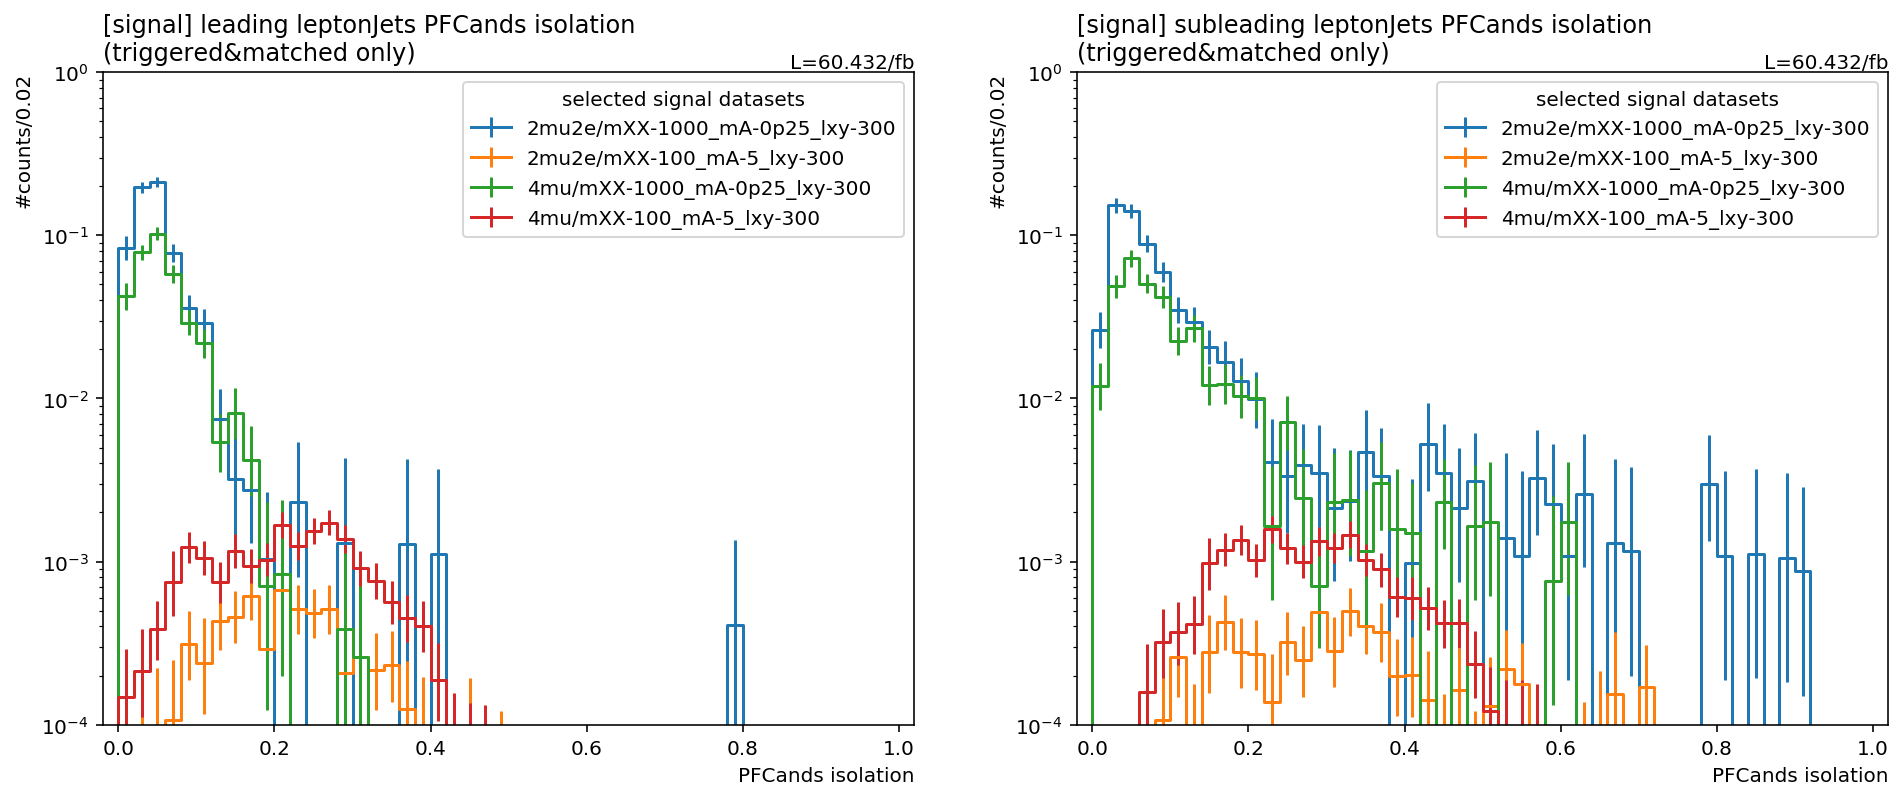

In [13]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_pfiso'], overlay='dataset', ax=axes[0], density=False, overflow='all')
hist.plot1d(output['subl_pfiso'], overlay='dataset', ax=axes[1], density=False, overflow='all')

axes[0].set_title('[signal] leading leptonJets PFCands isolation\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets PFCands isolation\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-4, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

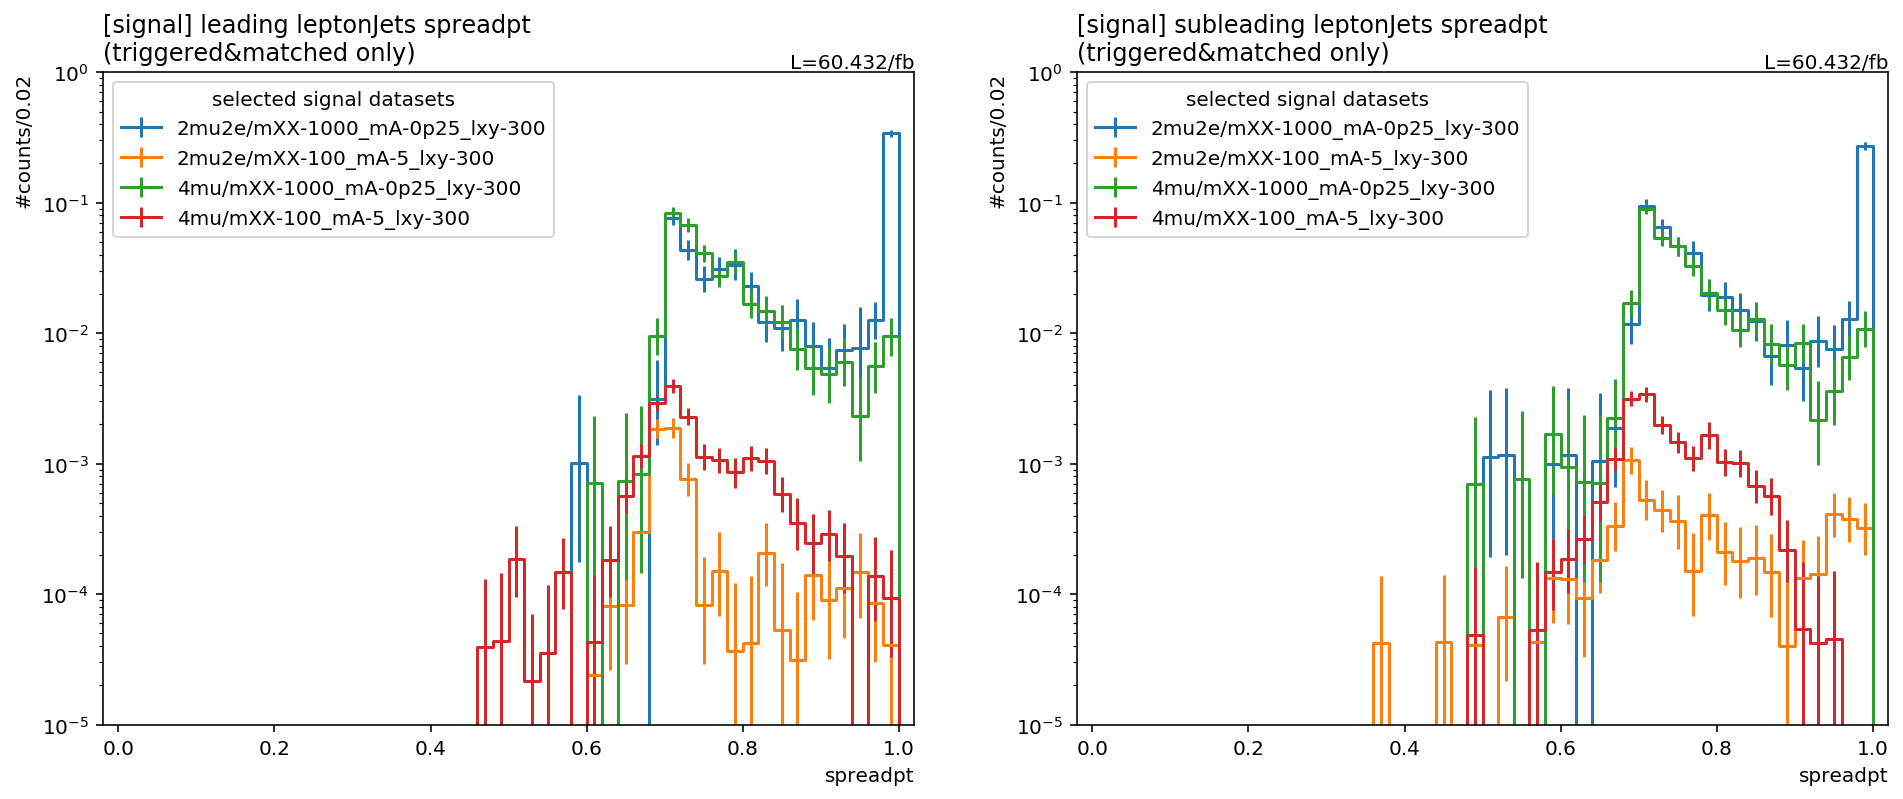

In [14]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_spreadpt'], overlay='dataset', ax=axes[0], density=False, overflow='all')
hist.plot1d(output['subl_spreadpt'], overlay='dataset', ax=axes[1], density=False, overflow='all')

axes[0].set_title('[signal] leading leptonJets spreadpt\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets spreadpt\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

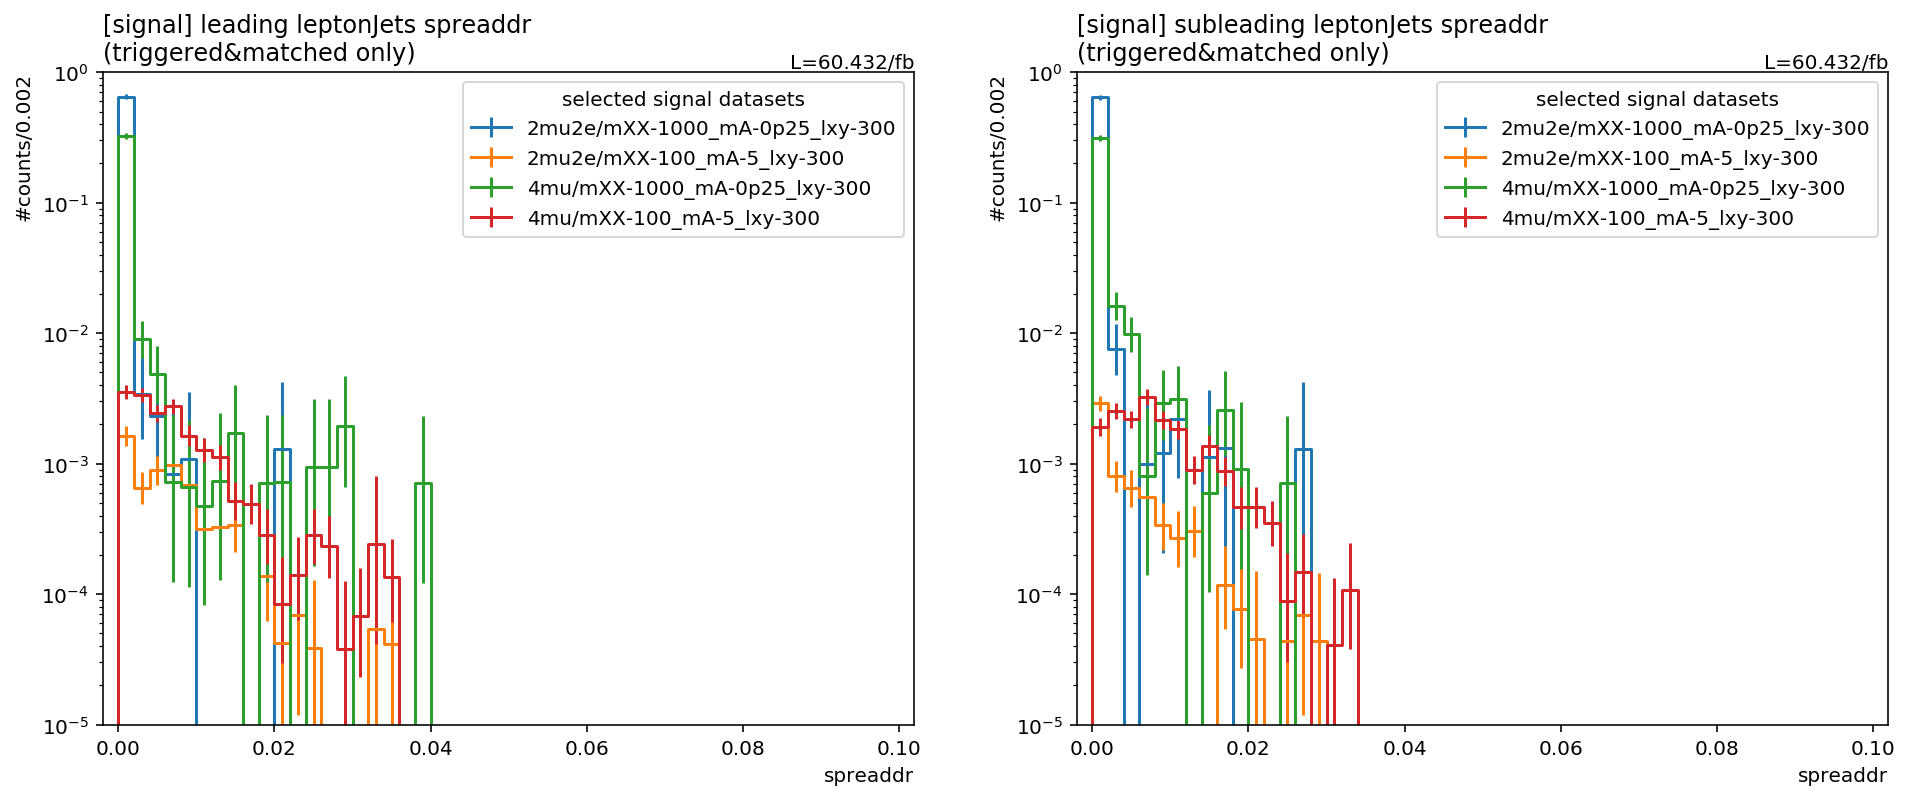

In [15]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_spreaddr'], overlay='dataset', ax=axes[0], density=False, overflow='all')
hist.plot1d(output['subl_spreaddr'], overlay='dataset', ax=axes[1], density=False, overflow='all')

axes[0].set_title('[signal] leading leptonJets spreaddr\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets spreaddr\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

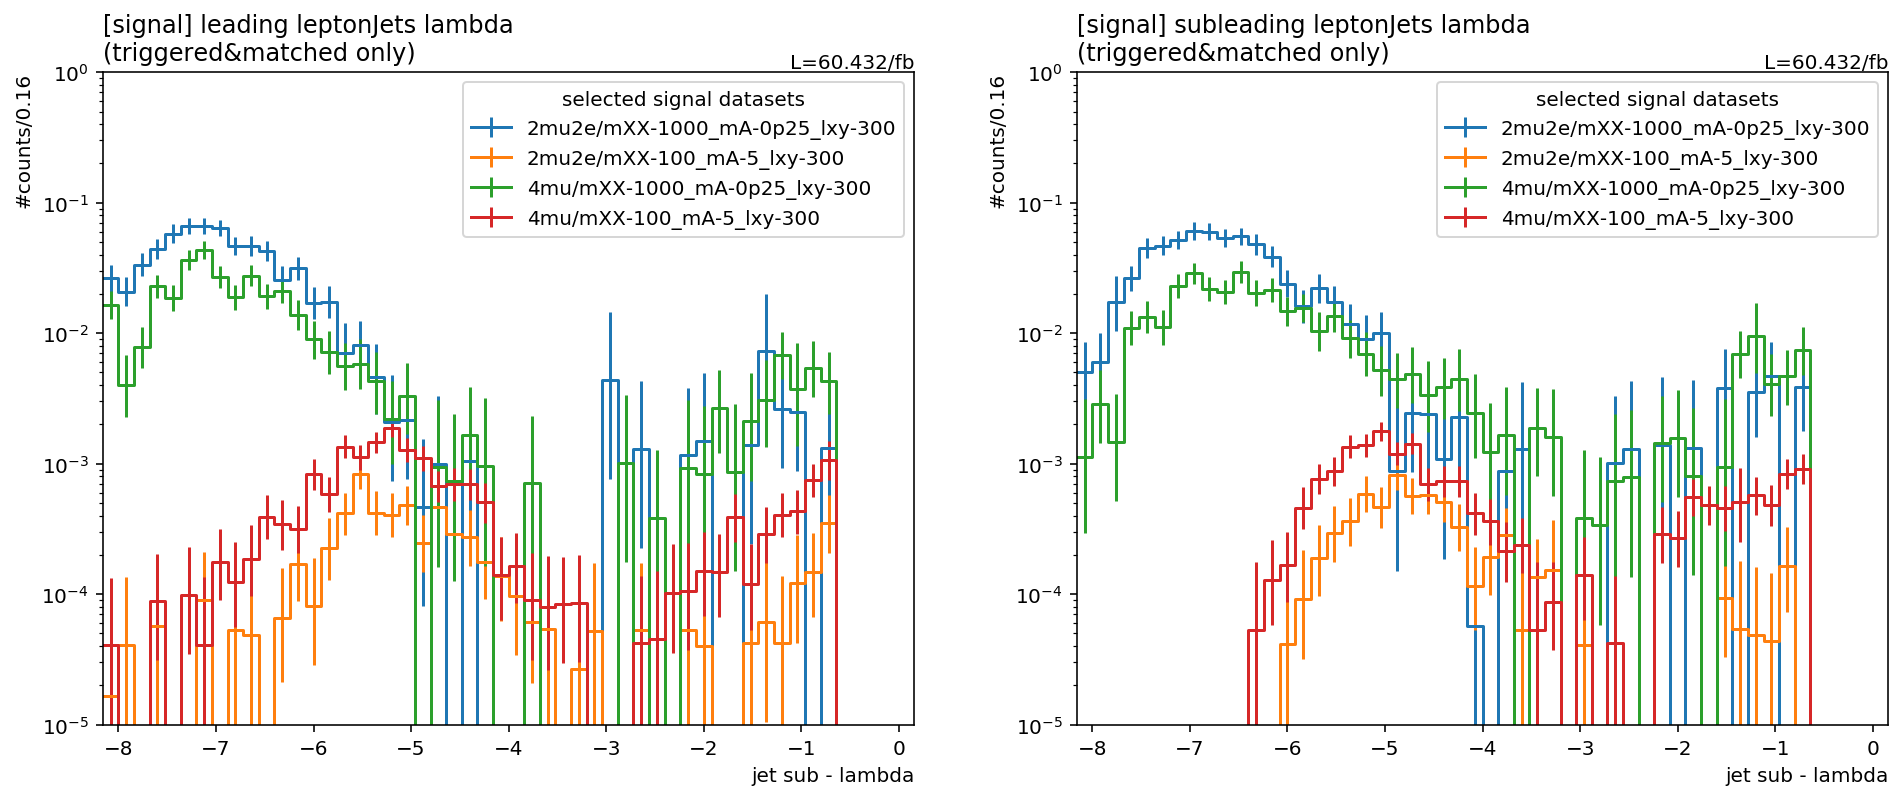

In [16]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_lamb'], overlay='dataset', ax=axes[0], density=False, overflow='all')
hist.plot1d(output['subl_lamb'], overlay='dataset', ax=axes[1], density=False, overflow='all')

axes[0].set_title('[signal] leading leptonJets lambda\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets lambda\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

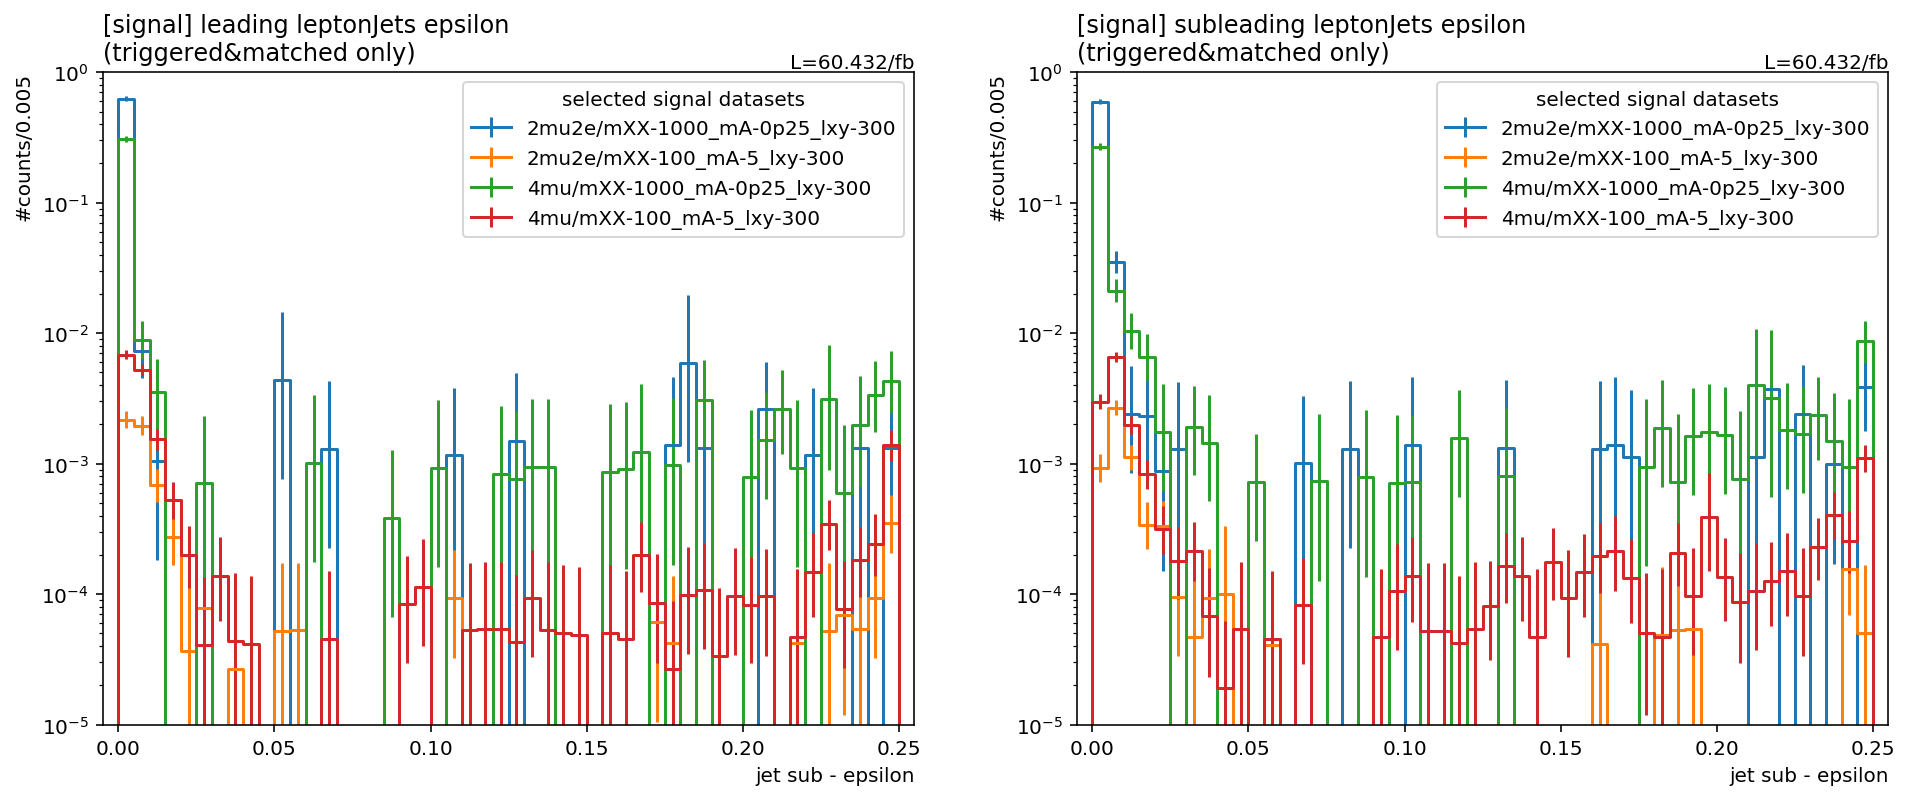

In [17]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_epsi'], overlay='dataset', ax=axes[0], density=False, overflow='all')
hist.plot1d(output['subl_epsi'], overlay='dataset', ax=axes[1], density=False, overflow='all')

axes[0].set_title('[signal] leading leptonJets epsilon\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets epsilon\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

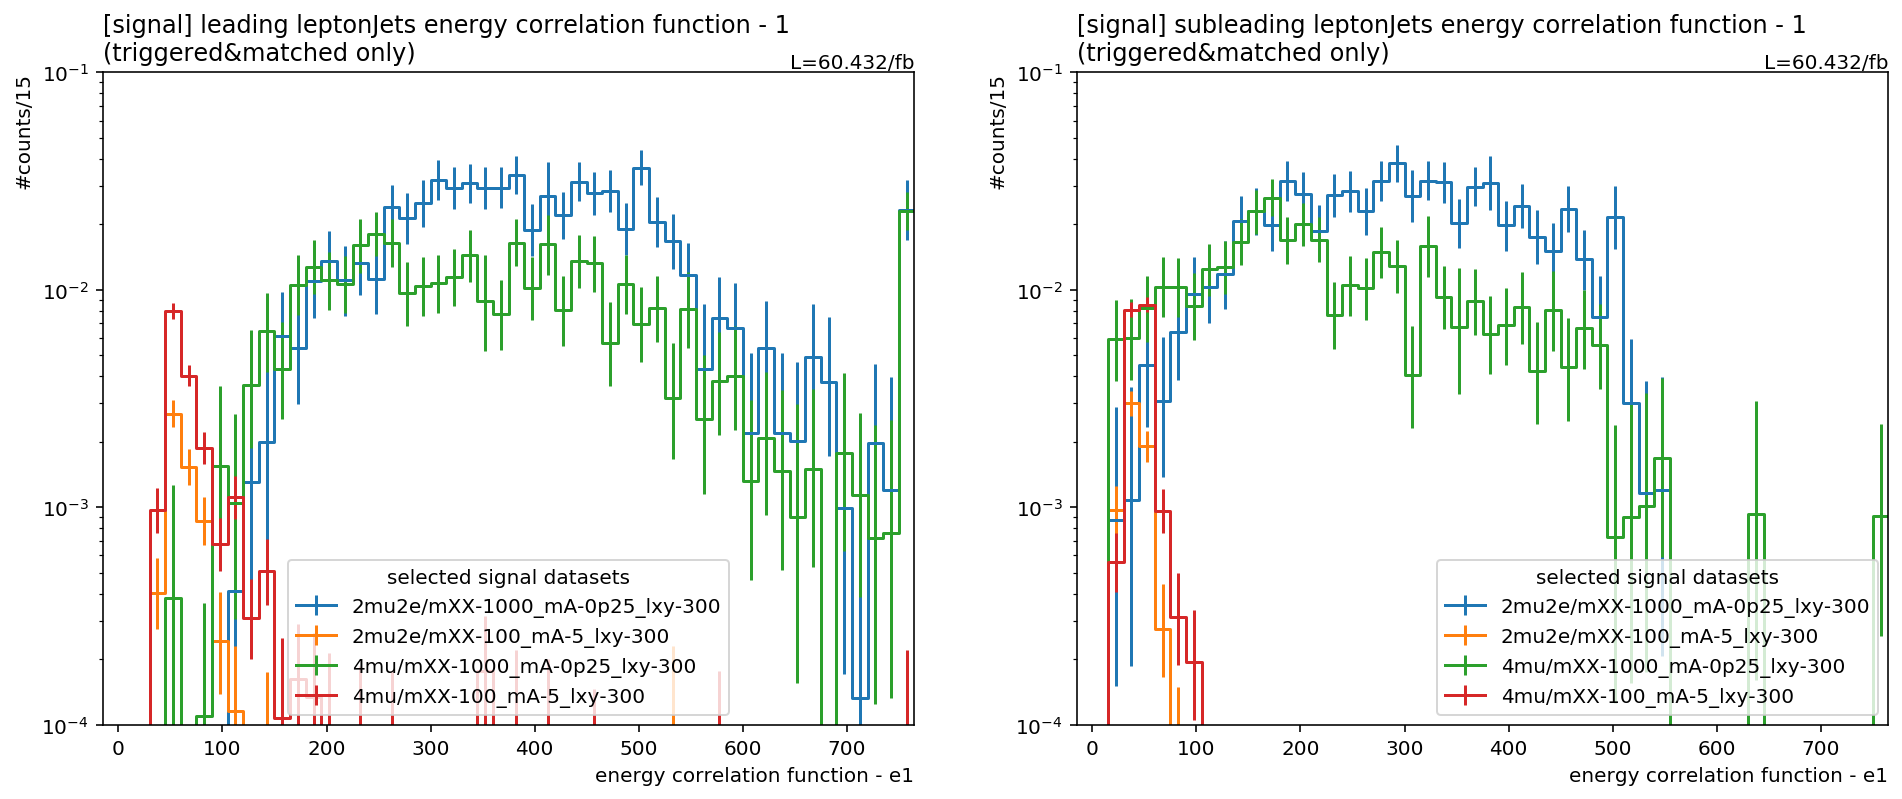

In [18]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_ecfe1'], overlay='dataset', ax=axes[0], density=False, overflow='all')
hist.plot1d(output['subl_ecfe1'], overlay='dataset', ax=axes[1], density=False, overflow='all')

axes[0].set_title('[signal] leading leptonJets energy correlation function - 1\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets energy correlation function - 1\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-4, 1e-1])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

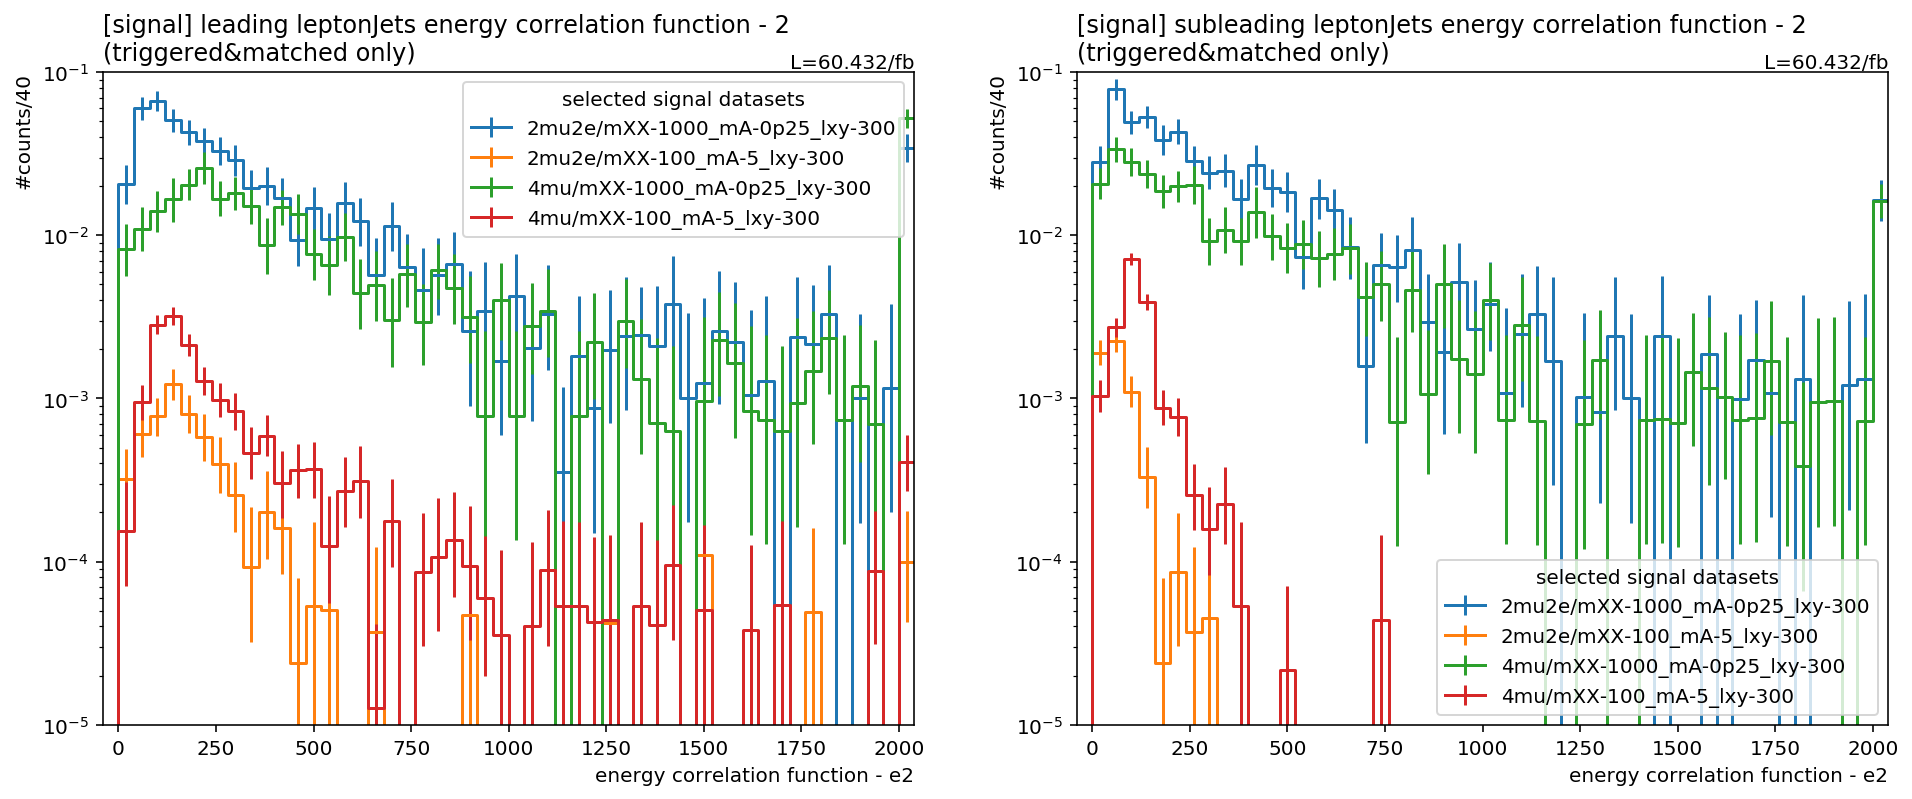

In [19]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_ecfe2'], overlay='dataset', ax=axes[0], density=False, overflow='all')
hist.plot1d(output['subl_ecfe2'], overlay='dataset', ax=axes[1], density=False, overflow='all')

axes[0].set_title('[signal] leading leptonJets energy correlation function - 2\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets energy correlation function - 2\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e-1])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

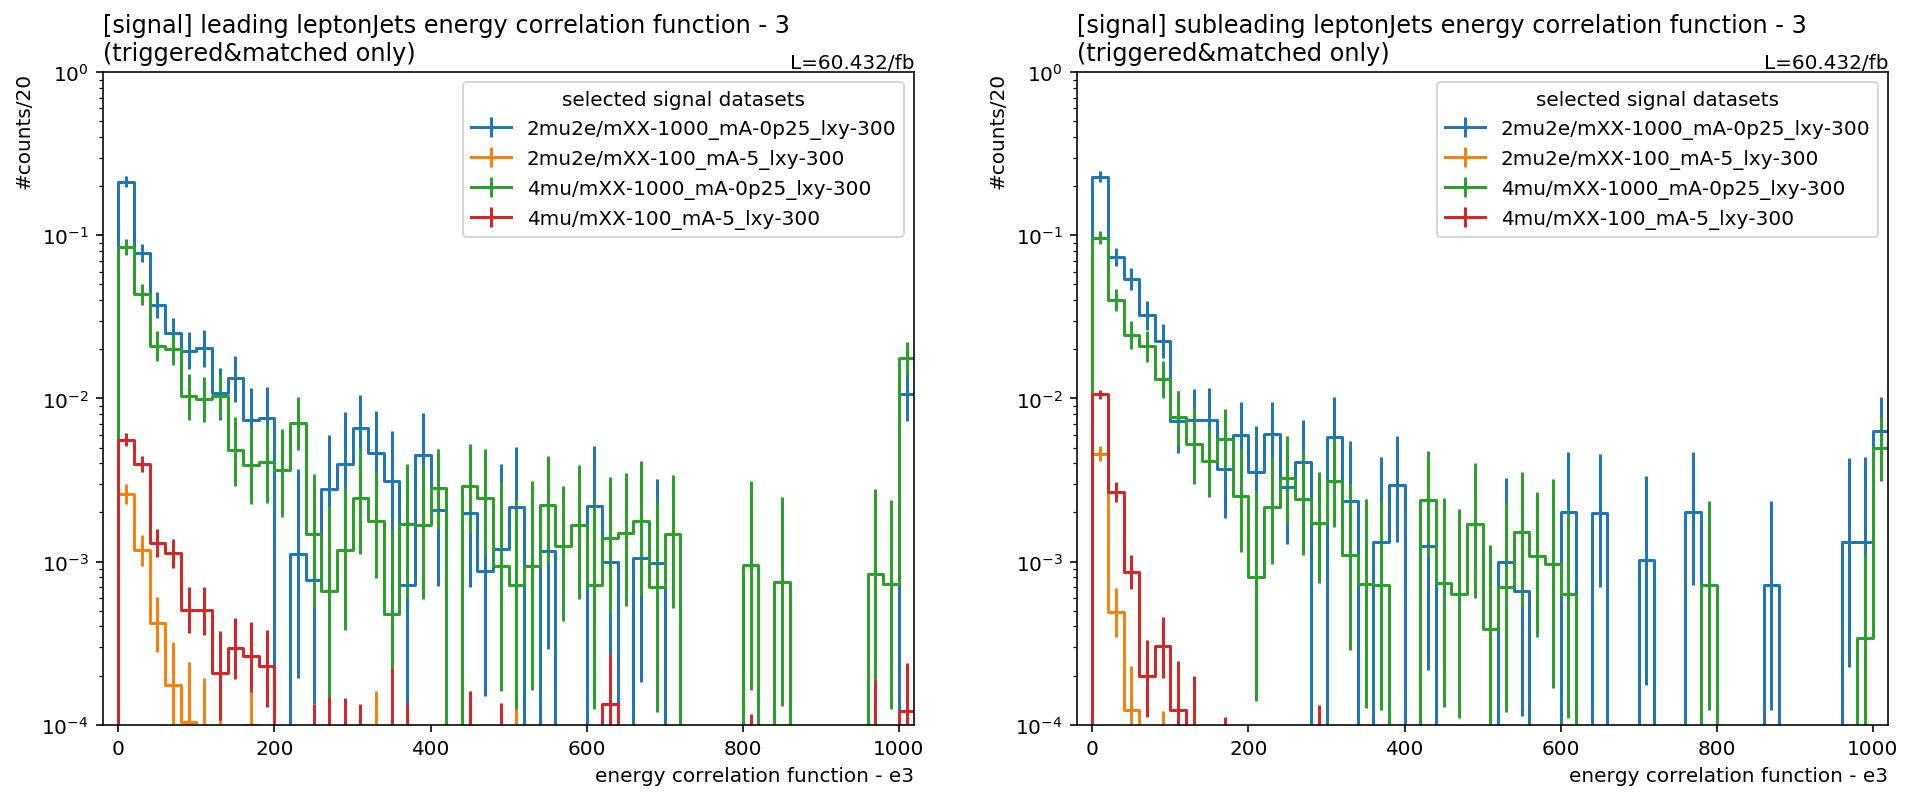

In [20]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_ecfe3'], overlay='dataset', ax=axes[0], density=False, overflow='all')
hist.plot1d(output['subl_ecfe3'], overlay='dataset', ax=axes[1], density=False, overflow='all')

axes[0].set_title('[signal] leading leptonJets energy correlation function - 3\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets energy correlation function - 3\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-4, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')

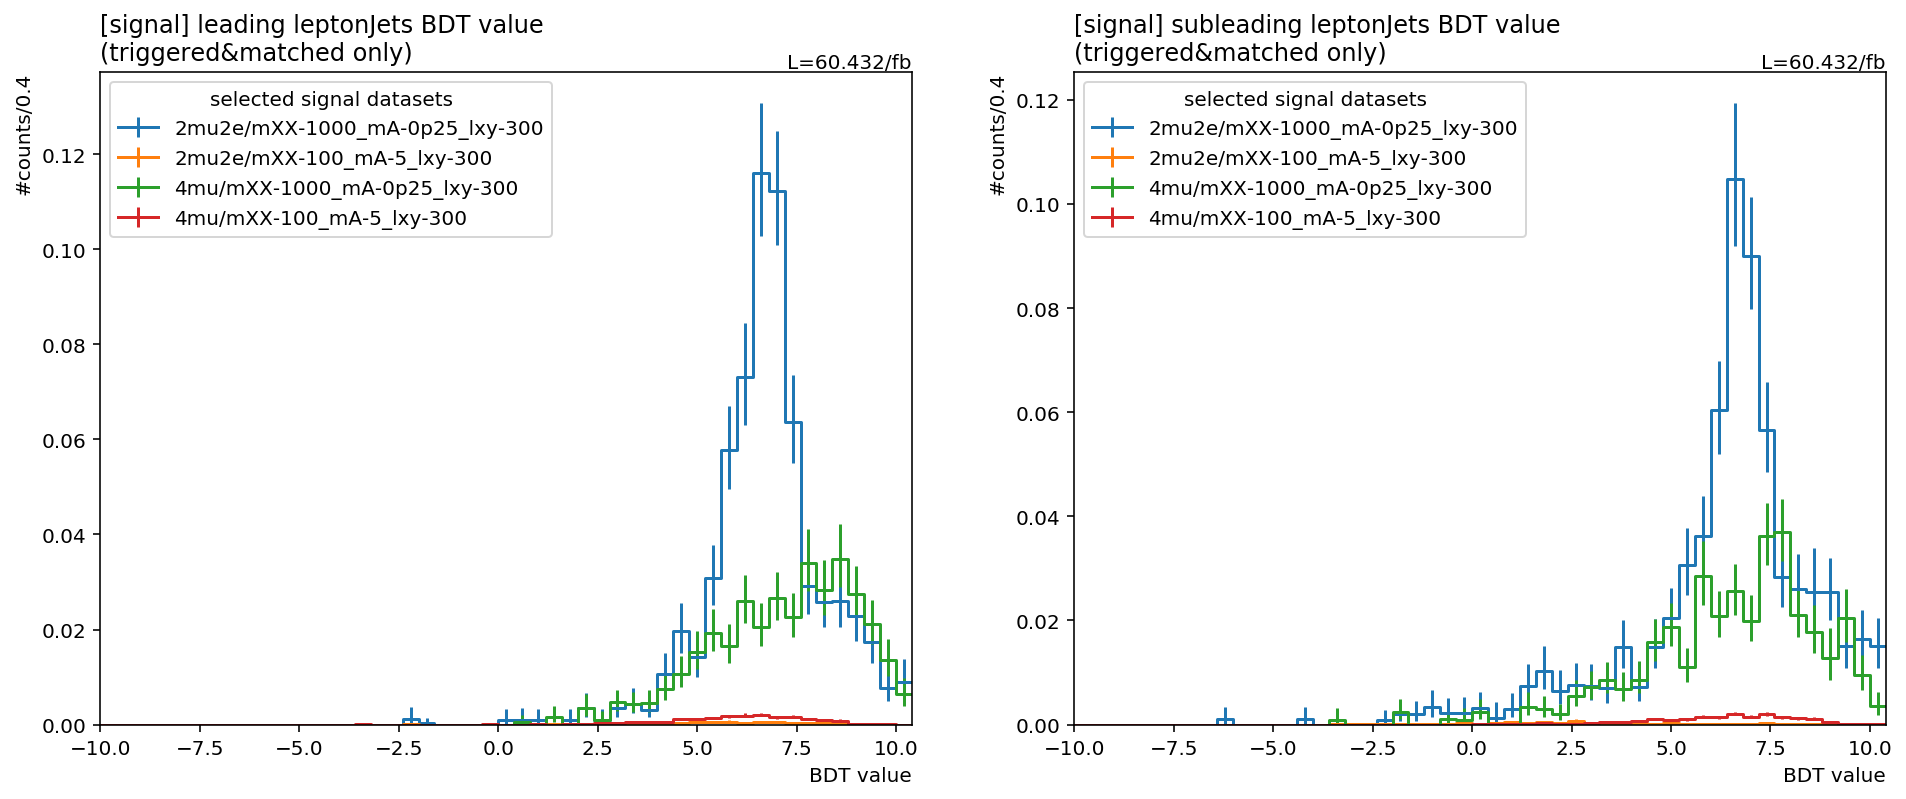

In [21]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['lead_mva'], overlay='dataset', ax=axes[0], density=False, overflow='over')
hist.plot1d(output['subl_mva'], overlay='dataset', ax=axes[1], density=False, overflow='over')

axes[0].set_title('[signal] leading leptonJets BDT value\n(triggered&matched only)', x=0.0, ha="left")
axes[1].set_title('[signal] subleading leptonJets BDT value\n(triggered&matched only)', x=0.0, ha="left")
for ax in axes:
    #ax.set_yscale('log')
    #ax.set_ylim([1e-4, 1e0])
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'L=60.432/fb', transform=ax.transAxes, ha='right', va='bottom')